# 주요 질병 사망자 및 보건 환경 비교 분석
## - 6 - 종합 및 결론
(Comparative Analysis of Major Disease Deaths and Health Environment)
## 1. 소개
국가별 의료 관련 데이터들을 이용해, 국가별, 연간 질병 사망자 수와 의료 인프라 간의 관계를 분석해보고 시각화를 해본 프로젝트

## 2. 목표
- 각 데이터의 EDA와 시각화
- 비슷한 분류의 데이터를 하나로 합치기
- 의료 인프라와 질병 사망자 수 관계 찾기 및 분석

## 3. 데이터 셋
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&conn_path=I2)
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC01&conn_path=I2)
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC09&conn_path=I2)
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC14&conn_path=I2)
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC25&conn_path=I2)
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC24&conn_path=I2)
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAD21&conn_path=I2)
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json)

## 4. 구현

#### 라이브러리

In [1]:
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import cufflinks as cf
import chart_studio
import folium
from folium.plugins import MarkerCluster
import json

#### 한글 폰트 설정

In [2]:
from IPython.display import set_matplotlib_formats

def get_font_family():
    import platform
    system_name = platform.system()

    if system_name == "Darwin" :
        font_family = "AppleGothic"
    elif system_name == "Windows":
        font_family = "Malgun Gothic"
    else:
        !apt-get install fonts-nanum -qq  > /dev/null
        !fc-cache -fv

        import matplotlib as mpl
        mpl.font_manager._rebuild()
        findfont = mpl.font_manager.fontManager.findfont
        mpl.font_manager.findfont = findfont
        mpl.backends.backend_agg.findfont = findfont
        
        font_family = "NanumBarunGothic"
    return font_family

get_font_family()

plt.style.use("ggplot")

font_family = get_font_family()
plt.rc("font", family=font_family)
plt.rc("axes", unicode_minus=False)

set_matplotlib_formats("retina")

C:\Users\spec3\AppData\Local\Temp\ipykernel_5316\2328754805.py:32: DeprecationWarning:

`set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`



In [3]:
# 모든 데이터 공통 국가
country_intersection = ['룩셈부르크',  '네덜란드',  '영국',  '이탈리아',  '캐나다',  '오스트레일리아',  '한국',  '일본',  '스페인',  '헝가리',  '독일',  '에스토니아',  '그리스',  '슬로바키아',  '핀란드',  '벨기에',  '체코',  '슬로베니아',  '프랑스',  '스웨덴',  '노르웨이',  '뉴질랜드',  '라트비아',  '덴마크',  '오스트리아',  '포르투갈',  '아일랜드',  '아이슬란드']

#### Data Load
각 파트별로 EDA 및 시각화를 진행한 후, 최종적으로 전처리된 파일은 6개입니다.  
**종합 및 결론**에서 사용하는 데이터 파일은 다음과 같이 총 8개 입니다.
- [KOSIS 10만명당 주요사망원인별 사망률](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_death_rate`
- [KOSIS 의료종사자수](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_Nmw`
- [KOSIS 보건관련 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_service`
- [KOSIS 보건서비스 지출비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_service_common`
- [KOSIS 의약품 판매](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_medicion`
- [KOSIS 의약품 소비](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_medicion`
- [KOSIS 공공사회복지 지출](https://kosis.kr/statHtml/statHtml.do?orgId=101&tblId=DT_2KAAC13&vw_cd=MT_RTITLE&list_id=101_003_E&seqNo=&lang_mode=ko&language=kor&obj_var_id=&itm_id=&conn_path=MT_RTITLE) → `df_welfare`
- [geojson 데이터](https://github.com/dr5hn/countries-states-cities-database/blob/master/countries.json) → `countries.geo.edited.json`, `countries.json`

In [4]:
df_death_rate = pd.read_csv("data/pre_df/df_death_rate.csv")
df_Nmw = pd.read_csv("data/pre_df/df_Nmw.csv")
df_service = pd.read_csv("data/pre_df/df_service.csv")
df_service_common = pd.read_csv("data/pre_df/df_service_common.csv")
df_medicion = pd.read_csv("data/pre_df/df_medicion.csv")
df_welfare = pd.read_csv("data/pre_df/df_welfare.csv")

In [66]:
g_p = open("data/countries.geo.edited.json")
gp = open("data/countries.json")
geo_poly = json.load(g_p)
geo_point = pd.json_normalize(json.load(gp))
g_p.close()
gp.close()

In [6]:
print(f"df_death_rate: {df_death_rate.shape}\ndf_Nmw: {df_Nmw.shape}\ndf_service: {df_service.shape}\ndf_service_common: {df_service_common.shape}\ndf_medicion: {df_medicion.shape}\ndf_welfare: {df_welfare.shape}")

df_death_rate: (18507, 8)
df_Nmw: (1829, 7)
df_service: (3192, 5)
df_service_common: (3788, 11)
df_medicion: (4724, 5)
df_welfare: (893, 9)


### 통합 데이터 생성
앞서 사용한 데이터들을 집계 함수를 이용해 하나의 데이터로 생성합니다.
#### 1. 연간 평균 사망률

In [7]:
df_corr = pd.DataFrame(df_death_rate.groupby(["국가", "연도"])["사망률"].mean()).reset_index().copy()
df_corr.columns = ["국가", "연도", "평균 사망률"]
df_corr

,국가,연도,평균 사망률
0,그리스,1998,40.600000
1,그리스,1999,40.382857
2,그리스,2000,40.357143
3,그리스,2001,39.397143
4,그리스,2002,38.622857
...,...,...,...
523,헝가리,2013,56.522857
524,헝가리,2014,55.531429
525,헝가리,2015,56.282857
526,헝가리,2016,53.828571


#### 2. 평균 의료 종사자 수
치과의사와 약사를 제외한, 의사, 간호사들만 이용합니다

In [8]:
df_Nmw = df_Nmw[df_Nmw["직업"].isin(["의사", "간호사"])].reset_index(drop=True).copy()
df_Nmw.sample(5)

,국가,연도,직업,수,국가영문,위도,경도
367,독일,2003,의사,276643.0,germany,51.000000,9.000000
422,그리스,2019,간호사,36251.0,greece,39.000000,22.000000
489,아이슬란드,2009,의사,1162.0,iceland,65.000000,-18.000000
548,이탈리아,2014,간호사,320705.0,italy,42.833333,12.833333
826,스웨덴,2013,간호사,105162.0,sweden,62.000000,15.000000


평균 의료 종사자 수를 구합니다

In [9]:
temp = pd.DataFrame(df_Nmw.groupby(["국가", "연도"])["수"].mean()).reset_index().copy()
temp.columns = ["국가", "연도", "평균 의료 인력 수"]
temp.sample(5)

,국가,연도,평균 의료 인력 수
504,한국,2012,173181.5
372,오스트리아,2015,51367.0
185,벨기에,2019,36343.0
85,덴마크,2005,35009.0
265,아이슬란드,2007,2743.5


평균 사망률과 평균 의료 인력을 합칩니다.

In [10]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수
0,그리스,1998,40.600000,NaN
1,그리스,1999,40.382857,28452.0
2,그리스,2000,40.357143,29704.0
3,그리스,2001,39.397143,32068.0
4,그리스,2002,38.622857,36063.0
...,...,...,...,...
603,프랑스,2016,NaN,208266.0
604,프랑스,2017,NaN,210038.0
605,프랑스,2018,NaN,210567.0
606,헝가리,2017,NaN,48141.0


#### 3. 보건 관련 지출비
나라 간의 개인 생활 수준을 비교하기엔 PPP가 적합하므로 여러 항목 중 **1인당 보건지출(PPP)(US%)** 항목만을 이용합니다

In [11]:
temp = pd.DataFrame(df_service.groupby(["국가별", "연도", "항목"])["데이터값"].mean()).reset_index()
temp

,국가별,연도,항목,데이터값
0,그리스,2000,1인당 보건지출(PPP)(US$),1417.777954
1,그리스,2000,1인당 보건지출(US$),885.410400
2,그리스,2000,경상(GDP 대비%),7.243326
3,그리스,2000,공공(경상보건비 대비%),61.626427
4,그리스,2000,본인부담(경상보건비 대비%),36.272114
...,...,...,...,...
3187,헝가리,2018,1인당 보건지출(US$),1081.802856
3188,헝가리,2018,경상(GDP 대비%),6.700072
3189,헝가리,2018,공공(경상보건비 대비%),69.100578
3190,헝가리,2018,본인부담(경상보건비 대비%),26.914713


In [12]:
temp = temp[temp["항목"]=="1인당 보건지출(PPP)(US$)"].reset_index(drop=True).copy()
temp.columns = ["국가", "연도", "항목", "1인당 보건지출"]
temp = temp[["국가", "연도", "1인당 보건지출"]].copy()
temp

,국가,연도,1인당 보건지출
0,그리스,2000,1417.777954
1,그리스,2001,1678.575684
2,그리스,2002,1864.497559
3,그리스,2003,2019.099609
4,그리스,2004,2061.648193
...,...,...,...
527,헝가리,2014,1808.397217
528,헝가리,2015,1834.953613
529,헝가리,2016,1949.052490
530,헝가리,2017,2003.747681


In [13]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출
0,그리스,1998,40.600000,NaN,NaN
1,그리스,1999,40.382857,28452.0,NaN
2,그리스,2000,40.357143,29704.0,1417.777954
3,그리스,2001,39.397143,32068.0,1678.575684
4,그리스,2002,38.622857,36063.0,1864.497559
...,...,...,...,...,...
620,포르투갈,2017,NaN,NaN,3084.172852
621,포르투갈,2018,NaN,NaN,3242.351807
622,핀란드,2016,NaN,NaN,4211.662109
623,핀란드,2017,NaN,NaN,4339.905762


#### 4. 의약품 판매 소비  


In [14]:
temp = pd.DataFrame(df_medicion.groupby(["국가", "연도"])[["의약품소비량", "의약품판매량"]].mean()).reset_index()
temp.columns = ["국가", "연도", "평균 소비량", "평균 판매량"]
temp

,국가,연도,평균 소비량,평균 판매량
0,그리스,1998,29.609091,2032.8
1,그리스,1999,32.909091,2366.4
2,그리스,2000,35.681818,2398.1
3,그리스,2001,37.318182,2807.4
4,그리스,2002,40.245455,3557.4
...,...,...,...,...
496,헝가리,2016,46.436364,1772.0
497,헝가리,2017,47.063636,1796.5
498,헝가리,2018,48.454545,2240.1
499,헝가리,2019,50.290909,2183.7


In [15]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4
...,...,...,...,...,...,...,...
649,터키,2017,NaN,NaN,NaN,52.863636,6975.5
650,터키,2018,NaN,NaN,NaN,57.981818,6635.4
651,터키,2019,NaN,NaN,NaN,58.918182,7414.8
652,포르투갈,2020,NaN,NaN,NaN,67.940000,3208.7


#### 5. 보건 서비스와 공공사회
##### 보건 서비스

In [16]:
pd.Series(df_service_common["항목구분"].unique())

0         보건 당기 지출
1       치료 및 재활 치료
2            장기 치료
3        보건 보조 서비스
4              의료품
5             예방치료
6    정부의료체계 및 재정행정
dtype: object

보건 서비스 지출 내역에서, **치료 및 재활 치료, 장기 치료, 예방치료** 항목만 사용합니다.  
보건 보조 서비스는 인력, 정부의료체계 및 재정행정은 공공사회와 연관이 있고 의료품은 앞서 데이터를 가지고 있기 때문입니다.

In [17]:
temp = df_service_common[df_service_common["항목구분"].isin(["치료 및 재활 치료", "장기 치료", "예방치료"])].reset_index(drop=True)

In [18]:
temp = temp.groupby(["국가", "연도"])[["서비스비용(백만$)"]].mean().reset_index()
temp.columns = ["국가", "연도", "평균 치료비"]
temp

,국가,연도,평균 치료비
0,그리스,2003,506.273333
1,그리스,2004,575.290000
2,그리스,2005,625.670000
3,그리스,2006,648.686667
4,그리스,2007,769.300000
...,...,...,...
537,헝가리,2015,1701.903333
538,헝가리,2016,1776.880000
539,헝가리,2017,1956.316667
540,헝가리,2018,2131.090000


In [19]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8,NaN
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4,NaN
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1,NaN
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4,NaN
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4,NaN
...,...,...,...,...,...,...,...,...
649,터키,2017,NaN,NaN,NaN,52.863636,6975.5,NaN
650,터키,2018,NaN,NaN,NaN,57.981818,6635.4,NaN
651,터키,2019,NaN,NaN,NaN,58.918182,7414.8,NaN
652,포르투갈,2020,NaN,NaN,NaN,67.940000,3208.7,NaN


##### 공공 사회 복지 지출
`G`는 10억을 나타내는 SI 접두어 입니다.

In [20]:
temp = pd.DataFrame(df_welfare.groupby(["국가", "연도"])["복지비용(10억$)"].mean()).reset_index()
temp.columns = ["국가", "연도", "평균 복지 비용(G$)"]
temp

,국가,연도,평균 복지 비용(G$)
0,그리스,1998,2527.00
1,그리스,1999,2565.00
2,그리스,2000,2315.78
3,그리스,2001,2533.32
4,그리스,2002,2829.92
...,...,...,...
800,헝가리,2015,2552.04
801,헝가리,2016,2608.55
802,헝가리,2017,2817.10
803,헝가리,2018,3015.52


In [21]:
df_corr = pd.merge(left=df_corr, right=temp, how="outer", on=["국가", "연도"]).copy()
df_corr

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
0,그리스,1998,40.600000,NaN,NaN,29.609091,2032.8,NaN,2527.00
1,그리스,1999,40.382857,28452.0,NaN,32.909091,2366.4,NaN,2565.00
2,그리스,2000,40.357143,29704.0,1417.777954,35.681818,2398.1,NaN,2315.78
3,그리스,2001,39.397143,32068.0,1678.575684,37.318182,2807.4,NaN,2533.32
4,그리스,2002,38.622857,36063.0,1864.497559,40.245455,3557.4,NaN,2829.92
...,...,...,...,...,...,...,...,...,...
825,폴란드,2015,NaN,NaN,NaN,NaN,NaN,NaN,9651.56
826,폴란드,2016,NaN,NaN,NaN,NaN,NaN,NaN,10019.12
827,폴란드,2017,NaN,NaN,NaN,NaN,NaN,NaN,10951.20
828,폴란드,2018,NaN,NaN,NaN,NaN,NaN,NaN,12100.44


여러 데이터의 공통 항목들로 평균 값을 담고 있는데 데이터 프레임을 생성했습니다.  
`how=inner`로 `merge`를 진행한 경우, 한쪽에서 데이터가 존재하지 않으면 생성되지 않는 문제가 있어 `outer`로 진행했습니다.

### EDA 및 시각화

#### 전처리 및 초기 분석
이미 전처리된 데이터들을 이용했지만, 혹시 모르니 한 번 더 확인해봅니다.
##### 기본 정보 확인

In [22]:
df_corr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 830 entries, 0 to 829
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   국가            830 non-null    object 
 1   연도            830 non-null    int64  
 2   평균 사망률        528 non-null    float64
 3   평균 의료 인력 수    534 non-null    float64
 4   1인당 보건지출      532 non-null    float64
 5   평균 소비량        501 non-null    float64
 6   평균 판매량        501 non-null    float64
 7   평균 치료비        542 non-null    float64
 8   평균 복지 비용(G$)  783 non-null    float64
dtypes: float64(7), int64(1), object(1)
memory usage: 64.8+ KB


모든 데이터에서 공통으로 존재하는 데이터만 가져오니 데이터의 수가 급감했습니다.

##### 일부 행 제거하기
국가명이 **소계**인 데이터를 제거합니다.

In [23]:
df_corr = df_corr[~(df_corr["국가"]=="소계")].reset_index(drop=True).copy()

##### 결측치

In [24]:
df_corr.isnull().sum()

국가                0
연도                0
평균 사망률          280
평균 의료 인력 수      274
1인당 보건지출        276
평균 소비량          307
평균 판매량          307
평균 치료비          266
평균 복지 비용(G$)     25
dtype: int64

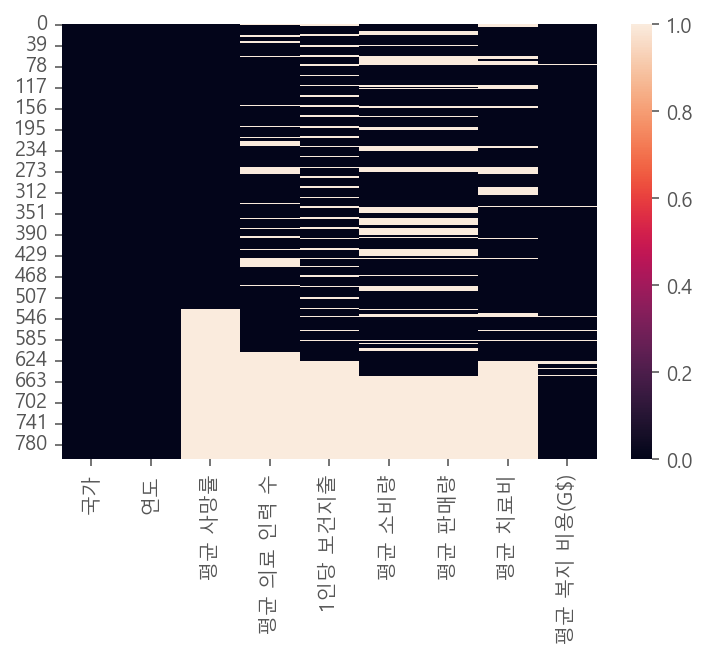

In [25]:
_ = sns.heatmap(data=df_corr.isnull())

In [26]:
df_corr.isnull().mean()*100

국가               0.000000
연도               0.000000
평균 사망률          34.653465
평균 의료 인력 수      33.910891
1인당 보건지출        34.158416
평균 소비량          37.995050
평균 판매량          37.995050
평균 치료비          32.920792
평균 복지 비용(G$)     3.094059
dtype: float64

공통 항목(국가, 연도)으로 데이터를 가져오다보니 결측치가 많습니다..  
특정 항목에 약 38% 정도 결측치가 있습니다.

##### 중복값

In [27]:
df_corr.duplicated().sum()

0

#### 기초 분석

In [28]:
# 대상 국가
for _ in [_ for _ in df_corr["국가"].unique()]:
    print(_, end=" / ")

그리스 / 네덜란드 / 노르웨이 / 뉴질랜드 / 덴마크 / 독일 / 라트비아 / 룩셈부르크 / 벨기에 / 스웨덴 / 스페인 / 슬로바키아 / 슬로베니아 / 아이슬란드 / 아일랜드 / 에스토니아 / 영국 / 오스트레일리아 / 오스트리아 / 이탈리아 / 일본 / 체코 / 캐나다 / 포르투갈 / 프랑스 / 핀란드 / 한국 / 헝가리 / 칠레 / 터키 / 리투아니아 / 멕시코 / 미국 / 스위스 / 이스라엘 / 폴란드 / 

In [29]:
df_corr.describe()

,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
count,808.00000,528.000000,534.000000,532.000000,501.000000,501.000000,542.000000,783.000000
mean,2008.72896,37.838503,121377.060861,3128.463919,45.083475,8114.379840,10636.853020,22079.815236
std,6.48835,14.016602,163685.180910,1372.261344,13.625571,11655.894161,24306.473450,48067.640823
min,1998.00000,19.775000,1288.000000,434.380096,9.300000,60.700000,0.000000,79.230000
25%,2003.00000,28.500714,17007.250000,2100.743958,37.200000,1360.000000,467.381667,2060.925000
50%,2009.00000,33.484286,52039.500000,2978.288940,45.050000,3247.300000,1931.058333,6377.540000
75%,2014.00000,41.083571,179022.250000,4165.573608,54.750000,8458.200000,9248.685833,14362.475000
max,2020.00000,87.348571,901425.000000,6818.346191,86.777778,87553.300000,172667.636667,400800.840000


||26개국의 평균치|
|:---:|:---:|
|주요 원인별 평균 사망률|37.8%|
|평균 의료 인력 수|121377명|
|1인당 평균 보건지출|3128.4 달러|
|평균 의약품 소비량|45개|
|평균 의약품 판매량|8114.3개(연간)|
|평균 치료비|10636.8 달러|
|평균 복지 비용| 220.79 조 원|

데이터는 1998부터 2020년까지의 데이터입니다.
 

In [30]:
df_corr[df_corr["평균 의료 인력 수"]==1288]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
141,룩셈부르크,2007,32.742857,1288.0,5277.879395,43.08,233.8,112.81,1028.18


In [31]:
df_corr[df_corr["평균 치료비"]==0]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
212,슬로바키아,2001,68.777143,17340.0,660.651733,45.218182,344.0,0.0,529.76


In [32]:
df_corr[df_corr["평균 판매량"]==60.7]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
284,에스토니아,1999,82.145714,6266.5,NaN,26.72,60.7,4.996667,88.16


In [33]:
df_corr[df_corr["평균 복지 비용(G$)"]==79.23]

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
285,에스토니아,2000,78.025714,6131.5,485.081024,27.57,66.4,3.966667,79.23


#### 사망률과 의료 인프라

In [34]:
df_corr.sample(5)

,국가,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
723,스위스,2001,NaN,NaN,NaN,NaN,NaN,NaN,4250.56
432,캐나다,2013,25.097143,210488.0,4552.959961,38.600000,23860.1,46996.116667,31392.20
441,포르투갈,2008,32.142857,NaN,2491.861816,49.170000,4931.5,728.496667,5823.06
597,캐나다,2015,NaN,222503.0,4729.486816,39.810000,21212.6,40799.740000,27861.35
643,터키,2011,NaN,NaN,NaN,33.881818,8458.2,NaN,9981.72


In [35]:
px.line(data_frame=df_corr, x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=6, width=1400, height=800, title="데이터 종합 (line)")

국가의 수가 많으니, 대률별로 그려보겠습니다.  
기존 데이터에 있던 대륙 정보를 이용하겠습니다.

In [36]:
temp = df_welfare[df_welfare["국가"].isin(country_intersection)][["대륙", "국가"]].drop_duplicates().reset_index(drop=True)
temp = pd.merge(left=temp, right=df_corr, on="국가", how="outer")
temp = temp[["국가", "대륙"]].drop_duplicates()

대륙 정보가 없는 경우 따로 처리를 해줬습니다.

In [37]:
asia = temp[(temp["대륙"]=="아시아") | (temp["대륙"]=="오세아니아")]["국가"].to_list()
europe = temp[temp["대륙"]=="유럽"]["국가"].to_list()
america = temp[temp["대륙"]=="북아메리카"]["국가"].to_list()

asia.extend(["터키", "이스라엘"])
europe.extend(["라투아니아", "스위스", "폴란드"])
america.extend(["칠레", "멕시코", "미국"])

개수를 확인합니다

In [38]:
df_corr["국가"].nunique() == len(asia)+len(europe)+len(america)

True

In [39]:
# 아시아
px.bar(data_frame=df_corr[df_corr["국가"].isin(asia)], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", barmode="overlay", title="데이터 종합 (아시아 / 오세아니아)")

In [40]:
# 아메리카
px.bar(data_frame=df_corr[df_corr["국가"].isin(america)], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", barmode="overlay", title="데이터 종합 (북미 / 남미)")

유럽은 국가가 많아 나눠 그렸습니다.

In [41]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[:10])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=5, barmode="overlay", title="데이터 종합 (유럽)")

In [42]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[10:20])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=5, barmode="overlay", title="데이터 종합 (유럽)")

In [43]:
# 유럽
px.bar(data_frame=df_corr[df_corr["국가"].isin(europe[20:])], x="연도", y=["평균 사망률", "평균 의료 인력 수", "1인당 보건지출", "평균 소비량", "평균 판매량", "평균 치료비", "평균 복지 비용(G$)"],\
    facet_col="국가", facet_col_wrap=3, barmode="overlay", title="데이터 종합 (유럽)")

#### 복지 비용 대비 보건료 지출

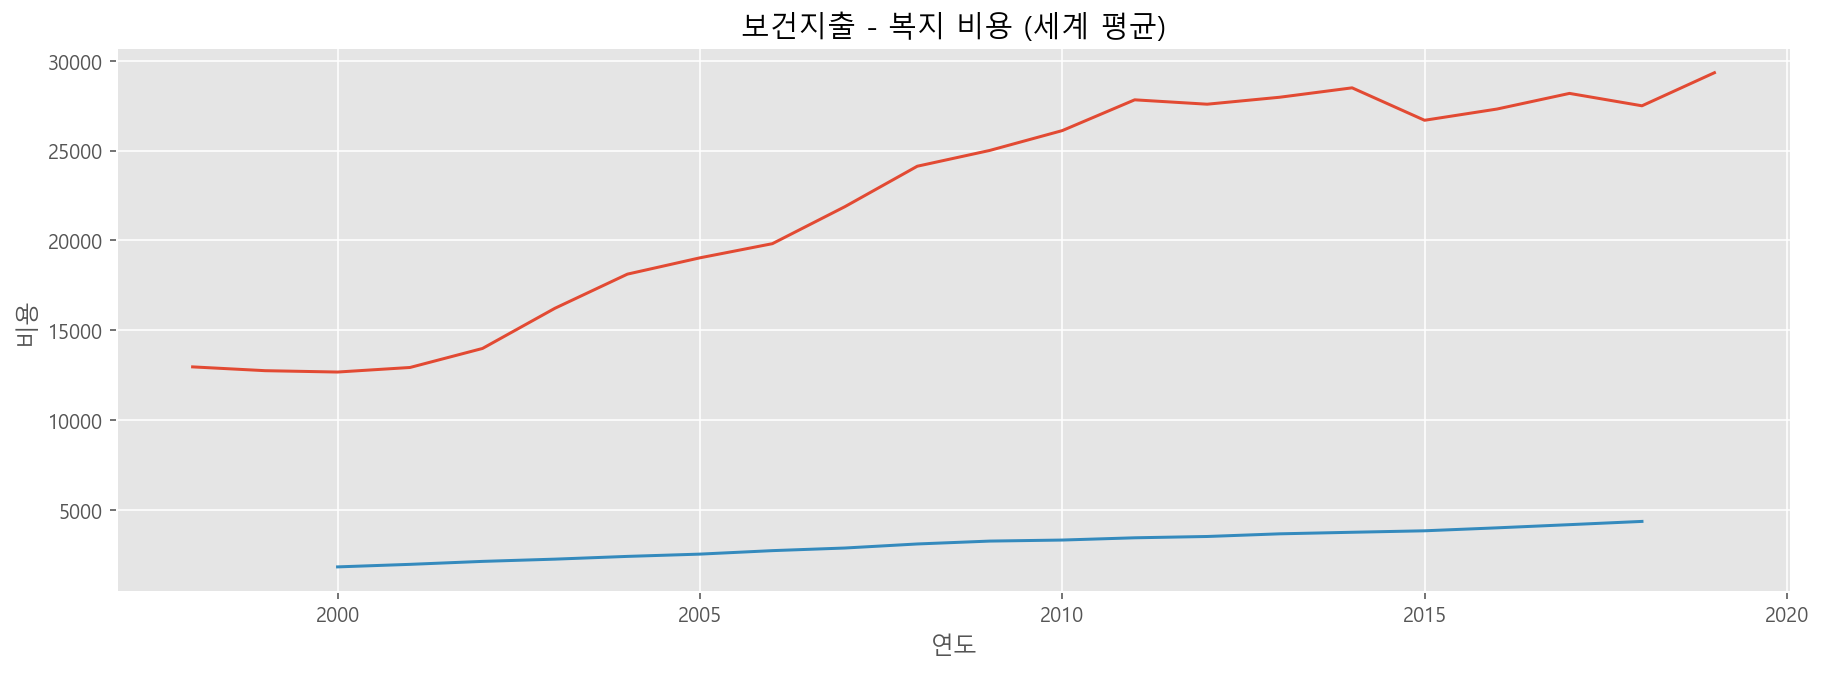

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax = sns.lineplot(data=df_corr, x="연도", y="평균 복지 비용(G$)", ci=None)
ax = sns.lineplot(data=df_corr, x="연도", y="1인당 보건지출", ci=None)
_ = ax.set_title("보건지출 - 복지 비용 (세계 평균)")
_ = ax.set_ylabel("비용")

In [45]:
df_corr["보건지출-복지비용 비율"] = df_corr["1인당 보건지출"]/df_corr["평균 복지 비용(G$)"]

In [46]:
px.area(data_frame=df_corr, x="연도", y="보건지출-복지비용 비율", color="국가", title="1인당 보건지출-복지비용 비율")

#### 보건 지출 대비 치료비

In [47]:
df_corr["보건지출-치료비 비율"] = df_corr["평균 치료비"] / df_corr["1인당 보건지출"]

In [48]:
px.area(data_frame=df_corr, x="연도", y="보건지출-치료비 비율", color="국가", title="1인당 보건지출-치료비 비율")

#### 보건 지출 대비 의약품 소비량

In [49]:
df_corr["보건지출-의약품 소비량 비율"] = df_corr["1인당 보건지출"] / df_corr["평균 소비량"]

In [50]:
px.area(data_frame=df_corr, x="연도", y="보건지출-의약품 소비량 비율", color="국가", title="보건지출-의약품 소비량 비율")

#### 의약품 판매량 대비 의약품 소비량

In [51]:
df_corr["의약품 판매량-의약품 소비량 비율"] = df_corr["평균 판매량"] / df_corr["평균 소비량"]

In [52]:
px.area(data_frame=df_corr, x="연도", y="의약품 판매량-의약품 소비량 비율", color="국가", title="의약품 판매량-의약품 소비량 비율")

#### 의료 인력 수 대비 평균 치료비

In [53]:
df_corr["의료 인력-평균 치료비 비율"] = df_corr["평균 치료비"] / df_corr["평균 의료 인력 수"]

In [54]:
px.area(data_frame=df_corr, x="연도", y="의료 인력-평균 치료비 비율", color="국가", title="의료 인력-평균 치료비 비율")

### 상관 계수 분석

In [77]:
df = df_corr[['국가', '연도', '평균 사망률', '평균 의료 인력 수', '1인당 보건지출', '평균 소비량', '평균 판매량', '평균 치료비', '평균 복지 비용(G$)']]

In [79]:
corr = df.corr()
corr

,연도,평균 사망률,평균 의료 인력 수,1인당 보건지출,평균 소비량,평균 판매량,평균 치료비,평균 복지 비용(G$)
연도,1.000000,-0.419451,0.137211,0.546067,0.430431,0.126220,0.113442,0.119352
평균 사망률,-0.419451,1.000000,-0.305054,-0.742939,-0.458375,-0.344344,-0.271593,-0.385051
평균 의료 인력 수,0.137211,-0.305054,1.000000,0.191464,0.106343,0.900279,0.646640,0.893769
1인당 보건지출,0.546067,-0.742939,0.191464,1.000000,0.410244,0.217899,0.164146,0.279299
평균 소비량,0.430431,-0.458375,0.106343,0.410244,1.000000,-0.023755,-0.051508,0.009964
평균 판매량,0.126220,-0.344344,0.900279,0.217899,-0.023755,1.000000,0.661818,0.952900
평균 치료비,0.113442,-0.271593,0.646640,0.164146,-0.051508,0.661818,1.000000,0.653461
평균 복지 비용(G$),0.119352,-0.385051,0.893769,0.279299,0.009964,0.952900,0.653461,1.000000


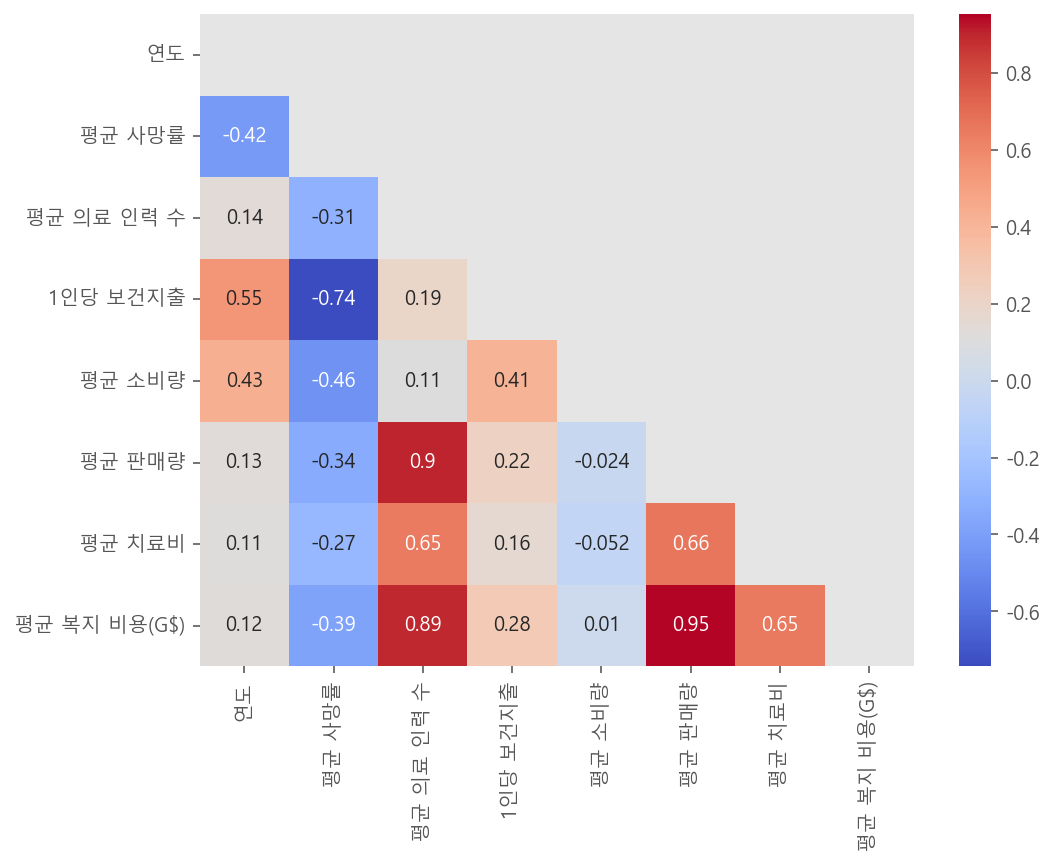

In [88]:
plt.figure(figsize=(8,6))
_ = sns.heatmap(data=corr, annot=True, cmap="coolwarm", mask=np.triu(np.ones_like(corr)))

주요 원인별 사망률과 의료 인프라 간의 상관계수는 음의 상관을 띄고 있습니다.  
즉, 의료 인프라와 관련된 변수의 값이 증가하면, 사망률은 감소한다는 것을 의미합니다.  
사망률과 가장 상관 관계가 큰 인프라는 **1인당 보건지출**입니다. 그 다음으로 의약품 소비량입니다.

## 5. 최종 결론 및 한계점